### Evaluator

This notebook implements an LLM-based assessment generation module.

The pipeline creates personalized assessments by:

1. Planning an assessment structure based on a topic and user profile;
2. Generating evaluation content for each step;
3. Storing user's answers for future evaluation;
4. Replanning after assessment disclosure based on progress.

#### Setup and Imports

In [1]:
import os
import operator
from typing import Annotated, Tuple, Union, TypedDict
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain.embeddings import init_embeddings
from langchain.chat_models import init_chat_model
from langchain.prompts import ChatPromptTemplate
from langgraph.types import Command, interrupt
from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph

#### Environment Configuration

In [2]:
load_dotenv(override = True)

True

In [3]:
THREAD = os.getenv("THREAD")
USER_ID = os.getenv("USER_ID")
OPENAI_CHAT_MODEL = os.getenv("OPENAI_CHAT_MODEL")
OPENAI_EMBED_MODEL = os.getenv("OPENAI_EMBED_MODEL")
OPENAI_API_PROXY = os.getenv("OPENAI_API_PROXY")
BASE_URL = os.getenv("BASE_URL")

In [4]:
llm = init_chat_model(api_key = OPENAI_API_PROXY, base_url = BASE_URL, model = OPENAI_CHAT_MODEL)

In [5]:
memory = MemorySaver()

In [ ]:
embeddings = init_embeddings(api_key = OPENAI_API_PROXY, base_url = BASE_URL, model = OPENAI_EMBED_MODEL)

In [7]:
store = InMemoryStore(index = {"embed": embeddings,"dims": 1536, "fields": ["memory", "type"]})

In [8]:
CONFIG = {'configurable': {'thread_id': THREAD, 'recursion_limit': 5, "user_id": USER_ID}}

#### Structured Output Models

In [9]:
class EvalExecute(TypedDict):
    """Structure for tracking and executing evaluation process."""
    input: str
    evaluations: list[str]
    past_evals: Annotated[list[Tuple], operator.add]
    evaluation_object: Annotated[list[Tuple], operator.add]
    answer: Annotated[list[Tuple], operator.add]
    sheet: str

In [10]:
class Eval(BaseModel):
    """Represents a single evaluation item."""
    title: str = Field(description="Concise title for the evaluation (3-7 words)")
    description: str = Field(description="Detailed description explaining the purpose and focus of this evaluation")

In [11]:
class Evaluations(BaseModel):
    """Collection of ordered evaluation items."""
    evals: list[Eval] = Field(description="Sequential list of evaluations that assess learning progress")

In [12]:
class EvalObject(BaseModel):
    """Specific evaluation content presented to the learner."""
    title: str = Field(description="Clear, descriptive title that identifies the evaluation item")
    content: str = Field(description="The actual evaluation content (question, multiple choice, code exercise, etc.)")
    evaluation_criteria: list[str] = Field(description="Specific learning objectives this evaluation assesses")


In [13]:
class Report(BaseModel):
    """Final summary of the assessment session."""
    report: str = Field(..., description = "Say: Assessment is over. Below are the QA's.")

In [14]:
class ActE(BaseModel):
    """Decision point for continuing assessment or concluding the evaluation flow."""
    action: Union[Report, Evaluations] = Field(
        description="Select either Evaluations (to continue with more assessment items) or Report (to finalize the evaluation process)"
    )

#### Prompts

In [15]:
mapper_ = """
    You are a Learning Experience Designer specializing in assessments.
    Your goal is to create structured evaluations with these characteristics:
        - Focused assessment items that evaluate distinct aspects of learning  (3-5 total)
        - Directly aligned with the provided lesson content
        - Clear evaluation criteria for each assessment item
        - No overlapping content between assessment items
    """

In [16]:
assessor_ = """
    You are an expert assessment designer.
    Create a precise 'EvalObject' with these characteristics:
        - Focused, well-structured evaluation content
        - Specific evaluation criteria that align with learning objectives
    """

In [17]:
remapper_ = mapper_ + """
    Evaluate assessment progress and determine next action:
    
    Lesson: {input}
    Original Evaluations: {evaluations}
    Completed Evaluations: {past_evals}

    Take one of these actions:
    - If both evaluation items are completed: Provide a Sheet with the assessment results
    - Otherwise: Update the evaluations with ONLY remaining items, maintaining original detail level
    
    Do not repeat previously completed evaluations nor create new items that were not present before.
    """

In [18]:
mapper_prompt = ChatPromptTemplate.from_messages([("system", mapper_),("placeholder", "{messages}")])
mapper = mapper_prompt | llm.with_structured_output(Evaluations)

In [19]:
assessment_prompt = ChatPromptTemplate.from_messages([("system", assessor_), ("placeholder", "{messages}")])
assessment = assessment_prompt | llm.with_structured_output(EvalObject)

In [20]:
remapper_prompt = ChatPromptTemplate.from_template(remapper_)
remapper = remapper_prompt | llm.with_structured_output(ActE)

#### LangGraph Nodes

In [21]:
def execute_eval(state: EvalExecute):
    evaluations = state["evaluations"]
    current_eval = evaluations[0]
    eval_str = "\n".join(f"{i+1}. {eval}" for i, eval in enumerate(evaluations, start=1))
    prompt = f"""Given this learning session content {state['input']}\n\n, 
                 and evaluation plan:\n{eval_str}\n\nYou are tasked with executing evaluation {1}: {current_eval}.
                 Questions / tasks must directly allign with the learning session content."""
    result = assessment.invoke({"messages": [("user", prompt)]})
    return {"past_evals": [current_eval], "evaluation_object": [result]}

def plan_eval(state: EvalExecute):
    evaluations = mapper.invoke({"messages": [("user", state["input"])]})
    return {"evaluations": evaluations.evals}

def remap_eval(state: EvalExecute):
    output = remapper.invoke(state)
    formatted_list = []
    for i, eval_obj in enumerate(state['evaluation_object'], 1):
        content = eval_obj.content.strip()
        formatted_list.append(f"{i}. {content}")
    prompt = f"Questions: {str(formatted_list)} | Answers: {str(state['answer'])}"
    return {"report": output.action.report + prompt} if isinstance(output.action, Report) else {"evaluations": output.action.evals}

def assess(state: EvalExecute):
    answer = interrupt("Please provide your answer: ")
    return {"answer": [answer]}

def should_end(state: EvalExecute):
    return END if state.get("report") else "evaluation_content"

In [31]:
evaluationflow = StateGraph(EvalExecute)

evaluationflow.add_node("planning", plan_eval)
evaluationflow.add_node("evaluation_content", execute_eval)
evaluationflow.add_node("replan", remap_eval)
evaluationflow.add_node("assessment", assess)

evaluationflow.add_edge(START, "planning")
evaluationflow.add_edge("planning", "evaluation_content")
evaluationflow.add_edge("evaluation_content", "assessment")
evaluationflow.add_edge("assessment", "replan")

evaluationflow.add_conditional_edges("replan", should_end, ["evaluation_content", END])

evaluator = evaluationflow.compile(checkpointer = memory)

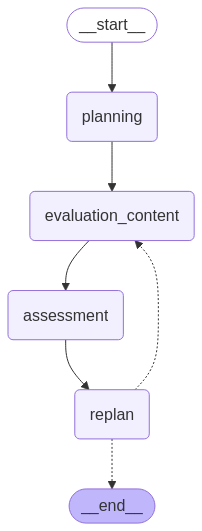

In [32]:
evaluator

#### Test Execution with HITL

In [ ]:
response = evaluator.invoke({"input": "Artificial Intellegence"}, config = CONFIG)

In [ ]:
for i, item in enumerate(response['evaluations'], start=1):
    print(f"\n{i}. {item.title.upper()}")
    print("-")
    print(f"{item.description}")


1. UNDERSTANDING AI BASICS
-
This assessment focuses on evaluating the student's understanding of the foundational principles and definitions of artificial intelligence, including types of AI, history, and major milestones. The evaluation will check the student's ability to describe what AI is and identify key developments that have shaped the field.

2. MACHINE LEARNING CONCEPTS
-
This evaluation is designed to assess the student's grasp of machine learning concepts within AI, such as supervised vs unsupervised learning, algorithms, and pivotal technologies. The aim is to ensure the student can explain these concepts and differentiate between the various types of machine learning processes.

3. AI APPLICATIONS IN REAL WORLD
-
This assessment evaluates the student's knowledge of how AI is applied in different industries and everyday scenarios. The student will be asked to identify real-world applications of AI, discussing their impact and the benefits they provide to fields like healt

In [ ]:
print(response['evaluation_object'][0].content)

1. Define Artificial Intelligence and briefly describe its primary goal. 
2. List and explain the different types of AI (e.g., Narrow AI, General AI, Strong AI) and provide an example of each type.
3. Outline the key historical milestones in the development of AI from inception to present day, highlighting significant breakthroughs.
4. Discuss the significance of the Turing Test in the evolution of AI.
5. Describe a major AI milestone in the past decade and explain its impact on the field of AI.


In [ ]:
response = evaluator.invoke(Command(resume = "continue"), config = CONFIG)

In [ ]:
print(response['answer'][0])

continue


In [ ]:
for i, item in enumerate(response['evaluations'], start=1):
    print(f"\n{i}. {item.title.upper()}")
    print("-")
    print(f"{item.description}")


1. MACHINE LEARNING CONCEPTS
-
This evaluation is designed to assess the student's grasp of machine learning concepts within AI, such as supervised vs unsupervised learning, algorithms, and pivotal technologies. The aim is to ensure the student can explain these concepts and differentiate between the various types of machine learning processes.

2. AI APPLICATIONS IN REAL WORLD
-
This assessment evaluates the student's knowledge of how AI is applied in different industries and everyday scenarios. The student will be asked to identify real-world applications of AI, discussing their impact and the benefits they provide to fields like healthcare, transportation, and data analysis.

3. ETHICAL IMPLICATIONS OF AI
-
This evaluation focuses on the student's ability to articulate the ethical considerations and debates surrounding the use of AI. Topics include privacy concerns, bias in AI systems, and the broader societal implications. The goal is to assess the student's critical thinking abou

In [ ]:
print(response['evaluation_object'][0].content)

1. Define Artificial Intelligence and briefly describe its primary goal. 
2. List and explain the different types of AI (e.g., Narrow AI, General AI, Strong AI) and provide an example of each type.
3. Outline the key historical milestones in the development of AI from inception to present day, highlighting significant breakthroughs.
4. Discuss the significance of the Turing Test in the evolution of AI.
5. Describe a major AI milestone in the past decade and explain its impact on the field of AI.
